# Data Prepration

# Loading pickles

In [1]:
import pickle

# english embeddings
en_embeddings = pickle.load( open("en_embeddings.p", "rb") )
en_keys = list(en_embeddings.keys())

# french embeddings
fr_embeddings = pickle.load( open("fr_embeddings.p", "rb") )
fr_keys = list(fr_embeddings.keys())

# Loading Train and Test

loading test and train and making unique words that has multiple french meaning

In [4]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("en-fr.train.txt", sep=" ", header=None, names = ['en', 'fr'])
train_df = train_df.groupby('en').apply(lambda x: x if len(x) == 1 else x.iloc[[-1]]).reset_index(drop=True)

test_df = pd.read_csv("en-fr.test.txt", sep=" ", header=None, names = ['en', 'fr'])
test_df = test_df.groupby('en').apply(lambda x: x if len(x) == 1 else x.iloc[[-1]]).reset_index(drop=True)


# Converting Train and Test To Matrix

train and test are just words, so we use pickles to convert them to vectors and hold them in matrix

In [5]:
# arrays for holding train vectors
train_en_mat = np.array([]).reshape(0, 300)
train_fr_mat = np.array([]).reshape(0, 300)

for i in range(len(train_df)):
    en_word = train_df.iloc[i][0]
    fr_word = train_df.iloc[i][1]
    
    if (en_word in en_keys) and (fr_word in fr_keys):
        
        train_en_mat = np.vstack((train_en_mat, np.array(en_embeddings[en_word])))
        train_fr_mat = np.vstack((train_fr_mat, np.array(fr_embeddings[fr_word])))

# arrays for holding test vectors
test_en_mat = np.array([]).reshape(0, 300)
test_fr_mat = np.array([]).reshape(0, 300)
test_df_h = test_df
for i in range(len(test_df)):
    en_word = test_df.iloc[i][0]
    fr_word = test_df.iloc[i][1]
    
    if (en_word in en_keys) and (fr_word in fr_keys):
        
        test_en_mat = np.vstack((test_en_mat, np.array(en_embeddings[en_word])))
        test_fr_mat = np.vstack((test_fr_mat, np.array(fr_embeddings[fr_word])))
    else:
        test_df_h = test_df_h.drop([i])

# Gradient Descent

code of gradient descent algorithm. In fit function we initialize random R array and in each iteration we update it to minimize the loss. In loss function we take two arrays and compute mse loss. In Gradient function we compute derivative of Loss base on R. In predict function we take test input and after converting it to french vector, we find similar vector in french vector to it. and in Score function we compute our guess

In [6]:
import numpy as np
from scipy.spatial.distance import cosine

class GradientDescent:
    def __init__(self, lr=0.1, num_iter=1000): 
        self.lr = lr
        self.num_iter = num_iter

    def loss(self, pred, Y):
        
        # difference of prediction and target
        diff = pred - Y
        
        # sum of squares of diff matrix
        sum_loss = sum([ element**2 for element in np.nditer(diff)])
        
        # return loss
        return sum_loss / len(pred)
    
    def gradient(self, X, Y, R):
        
        # finding m (size of row of matrix X)
        m = len(X)
        
        # calculating gradient matrix ( 2/m * X^T (XR - Y) )
        grad = (2 / m ) * ( X.T @ ( X @ R - Y ) )
        
        return grad
    
    def fit (self, X, Y) :
        
        # initial value of R
        R = np.random.random((X.shape[1], X.shape[1]))
        
        
        for i in range(self.num_iter):
            
            # Predict matrx, it can also be rewrite like np.dot(X, R)
            pred = X @ R
            
            # Computing loss
            loss_val = self.loss(pred, Y)
            
            # Computing gradient 
            grad_mat = self.gradient(X, Y, R)
            
            # new R
            R = R - self.lr * grad_mat
            
            # printing loss per iteration
            if(i % 20 == 0):
                print("Iteration " + str(i) + " loss = " + str(loss_val))
    
        return R
     
      
    def predict (self, Test_X, R) :
        
        # test prediction
        test_pred = Test_X @ R
        
        # Nearest vector to test_pred
        #Y_prime = np.array([]).reshape(0, 300)
        Y_prime = []
        for i in range(len(test_pred)):
            
            # holding nearest values
            max_val = 0
            max_key = 0
            
            # searching on all french vectors
            for key in fr_embeddings.keys():
                
                # cosine sim 
                cosine_val = 1 - cosine(test_pred[i], fr_embeddings[key])
                
                # if this vector is more similar update nearest values
                
                if(cosine_val > max_val):
                    max_val = cosine_val
                    max_key = key
            
            # assign nearest value to each predicted vector
            
            #Y_prime = np.vstack((Y_prime, np.array(fr_embeddings[max_key])))
            Y_prime.append(max_key)
        
        return Y_prime
      
      
    def score (self, Y, Y_prime) :
        # numbers of true predictions
        true_predict = 0
        for i in range(len(Y)):
            
            # if two vectors are completely the same
            #if( int(cosine(Y[i], Y_prime[i])) == 1 ):
            if( Y[i] == Y_prime[i] ):
                true_predict += 1
                
        # returning score
        return 100 * (true_predict / len(Y))
    

gd = GradientDescent(0.75, 450)

# Training

In [7]:
# train process
R_gd = gd.fit(train_en_mat, train_fr_mat)

Iteration 0 loss = 970.7303273194955
Iteration 20 loss = 144.0962578275381
Iteration 40 loss = 48.603680921960375
Iteration 60 loss = 20.28164405375254
Iteration 80 loss = 9.760331046800896
Iteration 100 loss = 5.263076428418619
Iteration 120 loss = 3.1351454580132487
Iteration 140 loss = 2.046409901235168
Iteration 160 loss = 1.454158369245238
Iteration 180 loss = 1.1160344228538361
Iteration 200 loss = 0.9154428025154071
Iteration 220 loss = 0.7927065721138972
Iteration 240 loss = 0.7156762630584025
Iteration 260 loss = 0.666287849349573
Iteration 280 loss = 0.6340347187912053
Iteration 300 loss = 0.6126286959115064
Iteration 320 loss = 0.5982150282855202
Iteration 340 loss = 0.5883818312160999
Iteration 360 loss = 0.5815928669702969
Iteration 380 loss = 0.5768540181424539
Iteration 400 loss = 0.5735127017880658
Iteration 420 loss = 0.5711348672754093
Iteration 440 loss = 0.5694282740397886


# Prediction and Score

In [9]:
import time

start = time.time()

# predicting translation in french and finding similar vectors from french pickles
Y_prime = gd.predict(test_en_mat, R_gd)

end = time.time()

print("time of searching for similar vectors = " + str(end-start))
score_test = gd.score(list(test_df_h['fr']), Y_prime)

print("test score = " + str(score_test))

time of searching for similar vectors = 363.09102725982666
test score = 42.767732962447845


# LSH

# Shingling or Vectorizing

this part is actually done by word2dec so we should'nt do anything

# Random Hyperplanes - Hashing

In [31]:
# convert a vector to sign(vector)
def binary_conv(row):
    
    return [1 if x >= 0 else 0 for x in row]

# convert a binary vector to int
def bin2dec(row):
    
    return int("".join(str(x) for x in row), 2)

def similar_word(word, list_similar_vector, list_similar_keys):
    
    # holding nearest values
    max_val = 0
    max_key = 0
        
    for i in range(len(list_similar_keys)):

        # cosine sim 
        cosine_val = 1 - cosine(word, list_similar_vector[i])

        # if this vector is more similar update nearest values

        if(cosine_val > max_val):
            max_val = cosine_val
            max_key = list_similar_keys[i]
            
    return max_key

class LSH:
    def __init__(self, num_planes=8, num_hashes=20): 
      
        
        # minimum is 8 due to question
        self.num_planes = num_planes

        # number of hash tables
        self.num_hashes = num_hashes
        
        # signature matrix
        self.signature_matrix = []
        self.signature_matrix_keys = []
        
        # norm of planes (considering planes passing through origin)
        self.norm_planes = []
        
    def random_hashing(self):
        # search vector
        french_vector = np.array(list(fr_embeddings.values()))

        for i in range(self.num_hashes):

            # generating norm of planes
            self.norm_planes.append(np.random.normal(size = (self.num_planes, 300)))

            # baskets
            baskets_vector = {}
            baskets_key = {}

            # number of baskets
            num_basket = 2 ** self.num_planes 

            # making a list for holding vectors
            for j in range(num_basket):
                baskets_vector[j] = []
                baskets_key[j] = []

            # finding side of each point from hyperplanes
            side_vector = french_vector @ self.norm_planes[i].T

            # convert it to binary
            binary_side = np.apply_along_axis(binary_conv, 1, side_vector)

            # convert binary to decimal as a hash value
            hash_value = np.apply_along_axis(bin2dec, 1, binary_side)

            # assign to baskets
            for j in range(len(hash_value)):
                baskets_vector[hash_value[j]].append(french_vector[j, :])
                baskets_key[hash_value[j]].append(fr_keys[j])

            self.signature_matrix.append(baskets_vector)
            self.signature_matrix_keys.append(baskets_key)

    
    def search(self, search_words):
    
        # similar words list
        sim_list = []
      
        for word in search_words:

            # list of similar vectors to each word
            list_similar_vector = []
            list_similar_keys = []

            for i in range(self.num_hashes):

                # finding side of each search word from hyperplanes
                side_vector = word @ self.norm_planes[i].T

                # convert it to binary
                binary_side = [1 if x >= 0 else 0 for x in side_vector]

                # convert binary to decimal as a hash value
                hash_value = int("".join(str(x) for x in binary_side), 2) 

                # hash table for i-th hash 
                hash_table = self.signature_matrix[i]
                hash_keys = self.signature_matrix_keys[i]

                # related baskets to word
                basket_vectors = hash_table[hash_value]
                basket_keys = hash_keys[hash_value]

                for j in range(len(basket_keys)):

                    if(basket_keys[j] not in list_similar_keys):
                        list_similar_keys.append(basket_keys[j])
                        list_similar_vector.append(basket_vectors[j])
                
            sim_list.append(similar_word(word, list_similar_vector, list_similar_keys))

        return sim_list


# Search

# Fixed number of Hyperplanes

In [ ]:
# parameters to check
number_hyperplanes = 8
number_hashes = [1, 4, 8, 12, 16, 20, 25]

# accuracy
acc_list = []

# time
time_list = []

# test prediction
test_pred = test_en_mat @ R_gd

for i in range(7):
    
    # lsh object
    lsh = LSH(number_hyperplanes, number_hashes[i])
    
    # hash french pickles into buckets
    lsh.random_hashing()
    
    start = time.time()
    # search for similar words
    Y_prime_lsh = lsh.search(test_pred)
    
    end = time.time()
    time_list.append(end - start)
    print(time_list[i])
    
    # score 
    score_test_lsh = gd.score(list(test_df_h['fr']), Y_prime_lsh)
    acc_list.append(score_test_lsh)
    print(acc_list[i])



Text(0, 0.5, 'Accuracy')

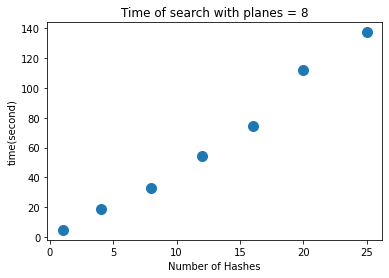

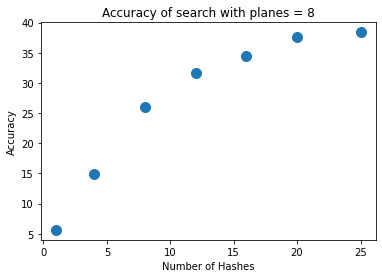

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(number_hashes, time_list, s=100)
plt.title("Time of search with planes = 8")
plt.xlabel("Number of Hashes")
plt.ylabel("time(second)")


plt.figure()
plt.scatter(number_hashes, acc_list, s=100)
plt.title("Accuracy of search with planes = 8")
plt.xlabel("Number of Hashes")
plt.ylabel("Accuracy")

# Fixed number of hash tables

In [ ]:
# parameters to check
number_hyperplanes = [6, 7, 8, 12, 15]
number_hashes = 15

# accuracy
acc_list = []

# time
time_list = []

# test prediction
test_pred = test_en_mat @ R_gd

for i in range(5):
    
    # lsh object
    lsh = LSH(number_hyperplanes[i], number_hashes)
    
    # hash french pickles into buckets
    lsh.random_hashing()
    
    start = time.time()
    # search for similar words
    Y_prime_lsh = lsh.search(test_pred)
    
    end = time.time()
    time_list.append(end - start)
    print(time_list[i])
    
    # score 
    score_test_lsh = gd.score(list(test_df_h['fr']), Y_prime_lsh)
    acc_list.append(score_test_lsh)
    print(acc_list[i])

Text(0, 0.5, 'Accuracy')

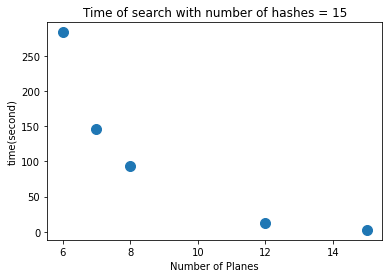

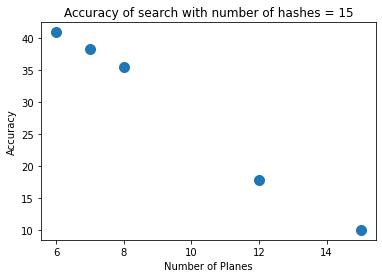

In [41]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(number_hyperplanes, time_list, s=100)
plt.title("Time of search with number of hashes = 15")
plt.xlabel("Number of Planes")
plt.ylabel("time(second)")


plt.figure()
plt.scatter(number_hyperplanes, acc_list, s=100)
plt.title("Accuracy of search with number of hashes = 15")
plt.xlabel("Number of Planes")
plt.ylabel("Accuracy")